In [1]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import dataFrameTools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
# from cloudpickle import CloudPickler
import tensorflow_probability as tfp
import random
from random import randrange

In [2]:
def loadData2():
    df=dataFrameTools.normalizeDF(0).astype('float32')
    images=[]
    for i in df.index.values:
        filePath=Path("../Processed Images/Grayscale/(" + str(i) + ").png")
        image=cv2.imread(str(filePath),0)
        images.append(image)
    images=np.array(images)
    #scale image values
    images=images/255.0
    split = train_test_split(df, images, test_size=0.25, random_state=42)
    dtrain, dtest, itrain, itest = split
    itrain=tf.expand_dims(itrain, -1)
    itest=tf.expand_dims(itest, -1)
    imdims=np.shape(itrain[1])
    ddims=len(dtrain.columns)
    return dtrain,dtest,itrain,itest,imdims,ddims

def custom_sigmoid_cross_entropy_loss_with_logits(x_true, x_recons_logits):
    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true, logits=x_recons_logits)
    if len(np.shape(x_true))==4:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])
    else:
        neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1])
    return tf.math.reduce_mean(neg_log_likelihood)

In [3]:
class imVAE:
    def __init__(self, imdims, latent_dim, kl_weight, learning_rate):
        self.dim_x = imdims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Flatten())
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e4"))
        return keras.Sequential(model, name='encoder')
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(30*65*32, name="layer1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Reshape(target_shape=(30, 65, 32)))

        model.append(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d1"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

#         model.append(layers.UpSampling2D((2,2)))
#         model.append(layers.Conv2D(filters=96, kernel_size=3, strides=(1,1),name="d2"))
#         model.append(layers.BatchNormalization())
#         model.append(layers.LeakyReLU())

        model.append(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))
        
#         model.append(keras.layers.Flatten())
#         model.append(tfp.layers.IndependentBernoulli(self.dim_x, name='x_layer'))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
        encoder.summary()
        decoder.summary()
        z = encoder(x_input)
        output=decoder(z)

        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model



In [4]:
dtrain,dtest,itrain,itest,imdims,ddims=loadData2()
imageVAE=imVAE(imdims, 32, 1, 1e-4).build_vae_keras_model()

Loaded Imputed Dataframe in  0.7701609134674072 seconds
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e1 (Conv2D)                  (None, 59, 129, 64)       640       
_________________________________________________________________
batch_normalization (BatchNo (None, 59, 129, 64)       256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 59, 129, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 59, 129, 64)       0         
_________________________________________________________________
e2 (Conv2D)                  (None, 12, 26, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 26, 128)       512       
_________________________________________________________________
lea

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = imageVAE.fit(x=itrain, y=itrain, epochs=300, batch_size=32, validation_data=(itest, itest),shuffle=True, callbacks=[callback])

Epoch 1/300
106/106 [==============================] - 11s 65ms/step - loss: 14163.4424 - val_loss: 16660.5254
Epoch 2/300
106/106 [==============================] - 6s 60ms/step - loss: 8338.2002 - val_loss: 12592.8008
Epoch 3/300
106/106 [==============================] - 7s 61ms/step - loss: 7265.8716 - val_loss: 10727.1572
Epoch 4/300
106/106 [==============================] - 7s 62ms/step - loss: 6855.7632 - val_loss: 8317.1201
Epoch 5/300
106/106 [==============================] - 6s 58ms/step - loss: 6629.1016 - val_loss: 6832.8369
Epoch 6/300
106/106 [==============================] - 6s 58ms/step - loss: 6483.6763 - val_loss: 6223.2949
Epoch 7/300
106/106 [==============================] - 6s 58ms/step - loss: 6342.8008 - val_loss: 6213.8916
Epoch 8/300
106/106 [==============================] - 6s 58ms/step - loss: 6260.4697 - val_loss: 6027.1191
Epoch 9/300
106/106 [==============================] - 6s 58ms/step - loss: 6182.7241 - val_loss: 5980.3872
Epoch 10/300
106/106 [=

106/106 [==============================] - 7s 71ms/step - loss: 5280.7061 - val_loss: 5599.0151
Epoch 77/300
106/106 [==============================] - 8s 74ms/step - loss: 5271.6133 - val_loss: 5544.3696
Epoch 78/300
106/106 [==============================] - 7s 64ms/step - loss: 5274.0649 - val_loss: 5574.9043
Epoch 79/300
106/106 [==============================] - 6s 60ms/step - loss: 5263.0918 - val_loss: 5561.4868
Epoch 80/300
106/106 [==============================] - 7s 67ms/step - loss: 5265.8472 - val_loss: 5571.6465
Epoch 81/300
106/106 [==============================] - 6s 60ms/step - loss: 5261.7603 - val_loss: 5583.2905
Epoch 82/300
106/106 [==============================] - 6s 60ms/step - loss: 5265.8823 - val_loss: 5580.0674
Epoch 83/300
106/106 [==============================] - 7s 65ms/step - loss: 5265.1035 - val_loss: 5572.5029
Epoch 84/300
106/106 [==============================] - 7s 61ms/step - loss: 5259.7808 - val_loss: 5554.2910
Epoch 85/300
106/106 [==========

Epoch 151/300
106/106 [==============================] - 6s 60ms/step - loss: 5114.5684 - val_loss: 5525.9609
Epoch 152/300
106/106 [==============================] - 6s 60ms/step - loss: 5118.3306 - val_loss: 5514.7686
Epoch 153/300
106/106 [==============================] - 7s 62ms/step - loss: 5111.8643 - val_loss: 5524.7769
Epoch 154/300
106/106 [==============================] - 6s 60ms/step - loss: 5108.0732 - val_loss: 5508.5508
Epoch 155/300
106/106 [==============================] - 6s 60ms/step - loss: 5110.2427 - val_loss: 5504.9546
Epoch 156/300
106/106 [==============================] - 6s 60ms/step - loss: 5119.3550 - val_loss: 5505.9966
Epoch 157/300
106/106 [==============================] - 6s 60ms/step - loss: 5109.3877 - val_loss: 5503.4902
Epoch 158/300
106/106 [==============================] - 6s 60ms/step - loss: 5097.7407 - val_loss: 5496.9102
Epoch 159/300
106/106 [==============================] - 6s 60ms/step - loss: 5118.6914 - val_loss: 5529.7783
Epoch 160/

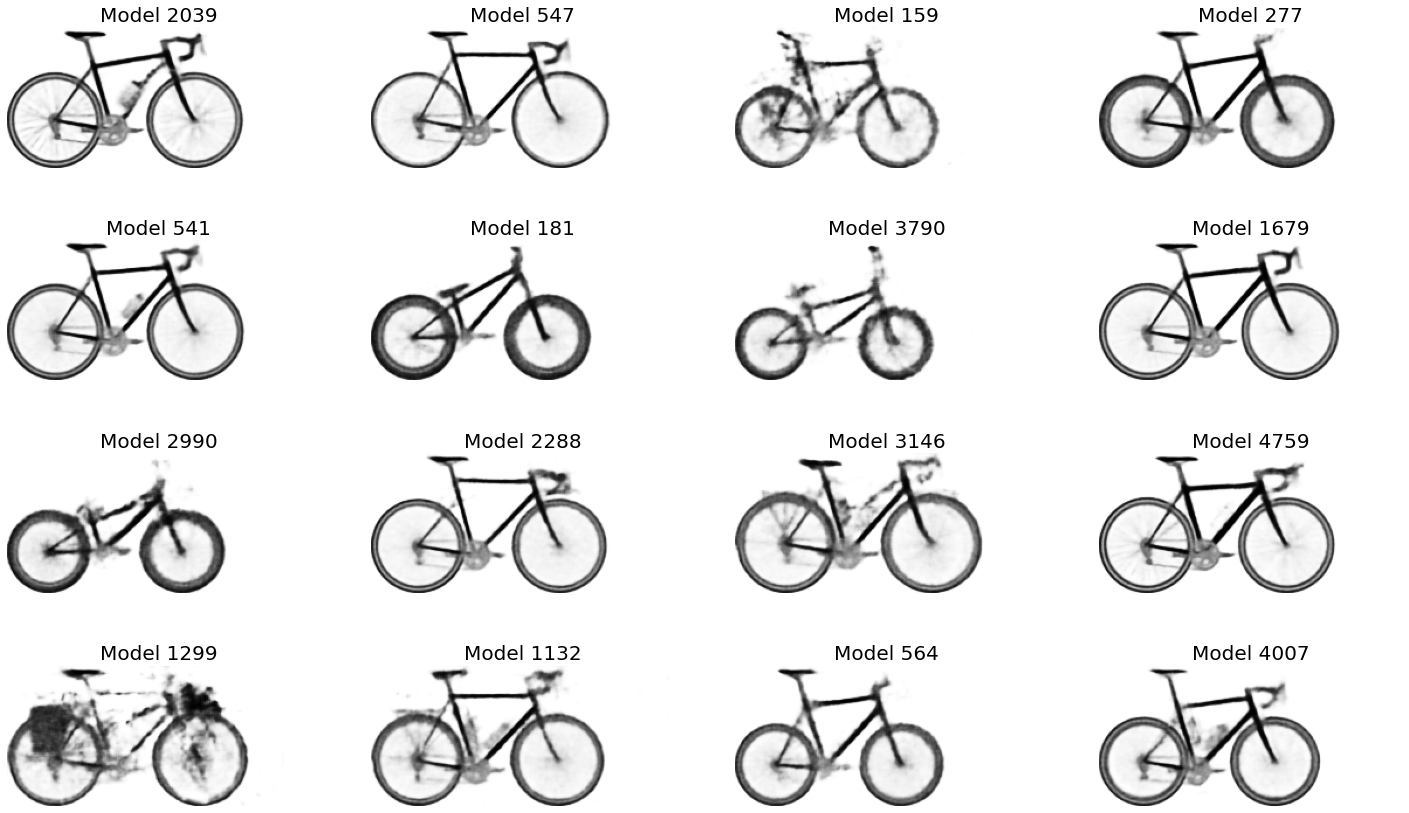

In [6]:
preds=(tf.math.sigmoid(imageVAE.predict(x=itest[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=dtest.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)
    plt.axis('off')
    

In [3]:
class dVAE:
    def __init__(self, datadims, latent_dim, kl_weight, learning_rate):
        self.dim_x = datadims
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        
        model=[layers.InputLayer(input_shape=self.dim_x)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e5"))
        
        model.append(tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6"))
        return keras.Sequential(model, name='encoder')
    
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(200, name="d0"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))

        model.append(layers.Dense(200, name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        model.append(layers.Dense(200, name="d4"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.05))
        
        
        model.append(layers.Dense(self.dim_x, name="d5"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.dim_x)
        encoder = self.encoder()
        decoder = self.decoder()
        encoder.summary()
        decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [4]:
dtrain,dtest,itrain,itest,imdims,ddims=loadData2()
dataVAE=dVAE(ddims, 128, 0.1, 2e-3).build_vae_keras_model()

Loaded Scaled Dataframe in  1.0514030456542969 seconds
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e0 (Dense)                   (None, 200)               495400    
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
e1 (Dense)                   (None, 200)               40200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200)               800       
_________________________________________________________________
leak

In [5]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
history = dataVAE.fit(x=dtrain, y=dtrain, epochs=5000, batch_size=20, validation_data=(dtest, dtest), callbacks=[callback])

Epoch 1/5000
170/170 [==============================] - 1s 8ms/step - loss: 668.3611 - val_loss: 634.6659
Epoch 2/5000
170/170 [==============================] - 1s 6ms/step - loss: 580.1957 - val_loss: 621.3276
Epoch 3/5000
170/170 [==============================] - 1s 6ms/step - loss: 574.2603 - val_loss: 587.3958
Epoch 4/5000
170/170 [==============================] - 1s 7ms/step - loss: 570.7138 - val_loss: 580.9086
Epoch 5/5000
170/170 [==============================] - 1s 6ms/step - loss: 568.5150 - val_loss: 586.5840
Epoch 6/5000
170/170 [==============================] - 1s 6ms/step - loss: 565.3948 - val_loss: 589.8119
Epoch 7/5000
170/170 [==============================] - 1s 6ms/step - loss: 563.0715 - val_loss: 579.9249
Epoch 8/5000
170/170 [==============================] - 1s 6ms/step - loss: 562.3475 - val_loss: 567.2292
Epoch 9/5000
170/170 [==============================] - 1s 7ms/step - loss: 560.2985 - val_loss: 568.5361
Epoch 10/5000
170/170 [=======================

170/170 [==============================] - 1s 7ms/step - loss: 530.5532 - val_loss: 532.3799
Epoch 154/5000
170/170 [==============================] - 1s 6ms/step - loss: 529.9839 - val_loss: 531.9974
Epoch 155/5000
170/170 [==============================] - 1s 7ms/step - loss: 530.0295 - val_loss: 534.1757
Epoch 156/5000
170/170 [==============================] - 1s 7ms/step - loss: 530.5077 - val_loss: 533.0439
Epoch 157/5000
170/170 [==============================] - 1s 7ms/step - loss: 529.7892 - val_loss: 532.5591
Epoch 158/5000
170/170 [==============================] - 1s 7ms/step - loss: 529.5788 - val_loss: 532.2761
Epoch 159/5000
170/170 [==============================] - 1s 7ms/step - loss: 530.3070 - val_loss: 531.9949
Epoch 160/5000
170/170 [==============================] - 1s 7ms/step - loss: 530.2455 - val_loss: 532.8335
Epoch 161/5000
170/170 [==============================] - 1s 7ms/step - loss: 530.0640 - val_loss: 533.0110
Epoch 162/5000
170/170 [===================

Epoch 229/5000
170/170 [==============================] - 1s 6ms/step - loss: 526.5870 - val_loss: 532.2261
Epoch 230/5000
170/170 [==============================] - 1s 7ms/step - loss: 527.1371 - val_loss: 531.7179
Epoch 231/5000
170/170 [==============================] - 1s 7ms/step - loss: 526.7545 - val_loss: 531.0692
Epoch 232/5000
170/170 [==============================] - 1s 7ms/step - loss: 527.3617 - val_loss: 530.9050
Epoch 233/5000
170/170 [==============================] - 1s 7ms/step - loss: 526.9645 - val_loss: 531.1403
Epoch 234/5000
170/170 [==============================] - 1s 7ms/step - loss: 526.8373 - val_loss: 531.0533
Epoch 235/5000
170/170 [==============================] - 1s 7ms/step - loss: 527.4545 - val_loss: 531.0474
Epoch 236/5000
170/170 [==============================] - 1s 7ms/step - loss: 526.9290 - val_loss: 531.2797
Epoch 237/5000
170/170 [==============================] - 1s 7ms/step - loss: 527.4326 - val_loss: 531.9527
Epoch 238/5000
170/170 [====

Epoch 305/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.3511 - val_loss: 530.5292
Epoch 306/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.7437 - val_loss: 530.4523
Epoch 307/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.9303 - val_loss: 530.2527
Epoch 308/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.9499 - val_loss: 530.4700
Epoch 309/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.6691 - val_loss: 530.2896
Epoch 310/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.9474 - val_loss: 530.4395
Epoch 311/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.8185 - val_loss: 530.1667
Epoch 312/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.5086 - val_loss: 530.0002
Epoch 313/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.5732 - val_loss: 530.3910
Epoch 314/5000
170/170 [====

Epoch 381/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.3403 - val_loss: 529.5490
Epoch 382/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.0131 - val_loss: 529.5188
Epoch 383/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.1523 - val_loss: 529.6500
Epoch 384/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.2922 - val_loss: 529.9423
Epoch 385/5000
170/170 [==============================] - 1s 7ms/step - loss: 524.2078 - val_loss: 529.5465
Epoch 386/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.1782 - val_loss: 530.3155
Epoch 387/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.7556 - val_loss: 529.5616
Epoch 388/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.8510 - val_loss: 529.4968
Epoch 389/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.4055 - val_loss: 529.6260
Epoch 390/5000
170/170 [====

Epoch 457/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.3674 - val_loss: 528.8645
Epoch 458/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.1099 - val_loss: 529.3641
Epoch 459/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.3444 - val_loss: 529.0439
Epoch 460/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.0047 - val_loss: 529.7660
Epoch 461/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.3064 - val_loss: 528.8140
Epoch 462/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.0502 - val_loss: 529.2311
Epoch 463/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.1649 - val_loss: 529.2834
Epoch 464/5000
170/170 [==============================] - 1s 7ms/step - loss: 523.1047 - val_loss: 529.6197
Epoch 465/5000
170/170 [==============================] - 1s 7ms/step - loss: 522.1606 - val_loss: 529.6589
Epoch 466/5000
170/170 [====

Epoch 533/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.0989 - val_loss: 528.7781
Epoch 534/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.1616 - val_loss: 528.5323
Epoch 535/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.2313 - val_loss: 529.1320
Epoch 536/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.5399 - val_loss: 529.0463
Epoch 537/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.9271 - val_loss: 529.1631
Epoch 538/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.3859 - val_loss: 529.1712
Epoch 539/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.3464 - val_loss: 529.0366
Epoch 540/5000
170/170 [==============================] - 1s 7ms/step - loss: 521.5197 - val_loss: 528.8461
Epoch 541/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.6802 - val_loss: 528.6423
Epoch 542/5000
170/170 [====

Epoch 609/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.5238 - val_loss: 528.3474
Epoch 610/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.3470 - val_loss: 528.7596
Epoch 611/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.4617 - val_loss: 528.5061
Epoch 612/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.2263 - val_loss: 528.4896
Epoch 613/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.5422 - val_loss: 528.6057
Epoch 614/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.3221 - val_loss: 528.5114
Epoch 615/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.3812 - val_loss: 528.4184
Epoch 616/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.9948 - val_loss: 528.5339
Epoch 617/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.3810 - val_loss: 528.7188
Epoch 618/5000
170/170 [====

Epoch 685/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.6431 - val_loss: 528.8048
Epoch 686/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.5294 - val_loss: 529.1602
Epoch 687/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.4594 - val_loss: 528.7452
Epoch 688/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.9891 - val_loss: 528.8282
Epoch 689/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.4375 - val_loss: 529.2731
Epoch 690/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.5631 - val_loss: 528.0061
Epoch 691/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.8096 - val_loss: 528.6400
Epoch 692/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.7274 - val_loss: 528.4780
Epoch 693/5000
170/170 [==============================] - 1s 7ms/step - loss: 520.4523 - val_loss: 528.0043
Epoch 694/5000
170/170 [====

Epoch 761/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.9894 - val_loss: 528.4238
Epoch 762/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.9169 - val_loss: 528.2656
Epoch 763/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.7720 - val_loss: 527.8704
Epoch 764/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.9173 - val_loss: 528.3265
Epoch 765/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.0920 - val_loss: 528.1078
Epoch 766/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1022 - val_loss: 528.6253
Epoch 767/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.4537 - val_loss: 528.7031
Epoch 768/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4462 - val_loss: 528.2797
Epoch 769/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.6041 - val_loss: 528.0958
Epoch 770/5000
170/170 [====

Epoch 837/5000
170/170 [==============================] - 1s 7ms/step - loss: 519.1408 - val_loss: 527.8401
Epoch 838/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.8021 - val_loss: 527.8242
Epoch 839/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4214 - val_loss: 528.3056
Epoch 840/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4696 - val_loss: 528.1608
Epoch 841/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4718 - val_loss: 528.0187
Epoch 842/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4893 - val_loss: 528.6854
Epoch 843/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1588 - val_loss: 527.9626
Epoch 844/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4356 - val_loss: 527.7296
Epoch 845/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.9702 - val_loss: 528.1113
Epoch 846/5000
170/170 [====

Epoch 913/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.8832 - val_loss: 527.9977
Epoch 914/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.2634 - val_loss: 528.3571
Epoch 915/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.5399 - val_loss: 528.2731
Epoch 916/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.7330 - val_loss: 527.4755
Epoch 917/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.9019 - val_loss: 527.8887
Epoch 918/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.4309 - val_loss: 527.9266
Epoch 919/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.5035 - val_loss: 527.8488
Epoch 920/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1503 - val_loss: 527.8115
Epoch 921/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1363 - val_loss: 528.0970
Epoch 922/5000
170/170 [====

Epoch 989/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.9056 - val_loss: 528.9175
Epoch 990/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.8226 - val_loss: 528.2022
Epoch 991/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.8922 - val_loss: 527.6311
Epoch 992/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.6075 - val_loss: 527.7841
Epoch 993/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.2589 - val_loss: 527.6045
Epoch 994/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.8663 - val_loss: 527.8494
Epoch 995/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.0889 - val_loss: 528.1127
Epoch 996/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.9258 - val_loss: 528.0135
Epoch 997/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1808 - val_loss: 527.3681
Epoch 998/5000
170/170 [====

170/170 [==============================] - 1s 7ms/step - loss: 516.7258 - val_loss: 527.7297
Epoch 1140/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.0927 - val_loss: 529.0812
Epoch 1141/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.9222 - val_loss: 527.1725
Epoch 1142/5000
170/170 [==============================] - 1s 7ms/step - loss: 518.1920 - val_loss: 528.0410
Epoch 1143/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.2794 - val_loss: 527.8951
Epoch 1144/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.8786 - val_loss: 527.4523
Epoch 1145/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.7584 - val_loss: 527.4280
Epoch 1146/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.3942 - val_loss: 527.5093
Epoch 1147/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.5129 - val_loss: 527.5036
Epoch 1148/5000
170/170 [==========

170/170 [==============================] - 1s 7ms/step - loss: 516.2043 - val_loss: 528.3443
Epoch 1290/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.8333 - val_loss: 527.4988
Epoch 1291/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.2635 - val_loss: 527.4250
Epoch 1292/5000
170/170 [==============================] - 1s 7ms/step - loss: 517.0931 - val_loss: 527.4455
Epoch 1293/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.4694 - val_loss: 527.9734
Epoch 1294/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.3030 - val_loss: 529.0184
Epoch 1295/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.7480 - val_loss: 527.7614
Epoch 1296/5000
170/170 [==============================] - 1s 6ms/step - loss: 516.0994 - val_loss: 528.0684
Epoch 1297/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.6604 - val_loss: 527.3954
Epoch 1298/5000
170/170 [==========

170/170 [==============================] - 1s 7ms/step - loss: 516.6033 - val_loss: 527.3951
Epoch 1440/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.8186 - val_loss: 527.4900
Epoch 1441/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.8221 - val_loss: 527.4084
Epoch 1442/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.8040 - val_loss: 527.5604
Epoch 1443/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.5812 - val_loss: 527.3570
Epoch 1444/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.4448 - val_loss: 527.9069
Epoch 1445/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.3221 - val_loss: 527.7816
Epoch 1446/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.6938 - val_loss: 528.2578
Epoch 1447/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.4105 - val_loss: 527.6660
Epoch 1448/5000
170/170 [==========

170/170 [==============================] - 1s 7ms/step - loss: 514.8071 - val_loss: 527.4307
Epoch 1590/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.5294 - val_loss: 527.6512
Epoch 1591/5000
170/170 [==============================] - 1s 7ms/step - loss: 516.0174 - val_loss: 527.3339
Epoch 1592/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.6034 - val_loss: 526.7368
Epoch 1593/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.2914 - val_loss: 527.2156
Epoch 1594/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.7863 - val_loss: 527.8316
Epoch 1595/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.7148 - val_loss: 527.9579
Epoch 1596/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.9687 - val_loss: 527.2399
Epoch 1597/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.4119 - val_loss: 527.6116
Epoch 1598/5000
170/170 [==========

170/170 [==============================] - 1s 7ms/step - loss: 515.4258 - val_loss: 527.3418
Epoch 1740/5000
170/170 [==============================] - 1s 7ms/step - loss: 514.8094 - val_loss: 527.2685
Epoch 1741/5000
170/170 [==============================] - 1s 6ms/step - loss: 515.5150 - val_loss: 527.7335
Epoch 1742/5000
170/170 [==============================] - 1s 7ms/step - loss: 514.9781 - val_loss: 527.4445
Epoch 1743/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.6916 - val_loss: 527.9788
Epoch 1744/5000
170/170 [==============================] - 1s 7ms/step - loss: 514.9443 - val_loss: 528.0439
Epoch 1745/5000
170/170 [==============================] - 1s 7ms/step - loss: 514.9969 - val_loss: 528.0491
Epoch 1746/5000
170/170 [==============================] - 1s 7ms/step - loss: 515.4813 - val_loss: 527.3659
Epoch 1747/5000
170/170 [==============================] - 1s 7ms/step - loss: 514.9901 - val_loss: 526.9968
Epoch 1748/5000
170/170 [==========

In [11]:
df=dataFrameTools.loadScaledDF().astype('float32')
preddata=df.loc[[2,3,4,10,12,14,18,22,45,50,56,61,72,80,85,91]]

numpred=16
# preds=(tf.math.sigmoid(dataVAE.predict(x=dtest[:numpred]))).numpy()
# preddf=pd.DataFrame(data=preds, columns=dtest.columns, index=dtest.index[:numpred])
preds=(tf.math.sigmoid(dataVAE.predict(x=preddata))).numpy()
preddf=pd.DataFrame(data=preds, columns=dtest.columns, index=preddata.index) 
preddf.to_csv('../Data/vaegendf.csv')  

Loaded Scaled Dataframe in  1.0979413986206055 seconds


In [11]:
#New interpolation Code
df=pd.read_csv("../data/BIKED_normalized.csv", index_col=0)
numgen=10000
latent=dataVAE.layers[1].predict(dtest.loc[[181,4007]])
l1=latent[0]
interpolated=np.zeros((numgen, len(l1)))
for i in range(numgen):
    idx1=dtest.index[random.randint(0,len(dtest.index)-1)]
    idx2=dtest.index[random.randint(0,len(dtest.index)-1)]
    twobikes=dtest.loc[[idx1,idx2]]
    latent=dataVAE.layers[1].predict(twobikes)
    l1=latent[0]
    l2=latent[1]
    scale=random.uniform(0,1)
    interpolated[i]=l1+scale*(l2-l1)
res=(tf.math.sigmoid(dataVAE.layers[2].predict(interpolated))).numpy()
indices=["vaeinterpolgen" +str(i) for i in range(numgen)]
interpolgendf=pd.DataFrame(res, index=indices, columns=df.columns)
interpolgendf.to_csv("../data/vaeinterpolgendf.csv")

In [12]:
#Random Generation
df=pd.read_csv("../data/BIKED_normalized.csv", index_col=0)
numgen=10000
latent=dataVAE.layers[1].predict(dtest.loc[[181,4007]])
latent=dataVAE.layers[1].predict(dtest)
generated=np.zeros((numgen, len(latent[0])))
for i in range(numgen):
    for j in range(len(latent[0])):
        idx=randrange(len(latent[:,0]))
        generated[i,j]=latent[idx, j]
res=(tf.math.sigmoid(dataVAE.layers[2].predict(generated))).numpy()
indices=["vaerand" +str(i) for i in range(numgen)]
interpolgendf=pd.DataFrame(res, index=indices, columns=df.columns)
interpolgendf.to_csv("../data/vaeranddf.csv")

In [97]:
twobikes=dtest.loc[[181,4007]]
latent=dataVAE.layers[1].predict(twobikes)
l1=latent[0]
l2=latent[1]

#interpolation code
num_interp=3
interpolated=np.zeros((num_interp, len(l1)))
for i in range(num_interp):
    interpolated[i]=l1+(l2-l1)*(i)/(num_interp+1)
res=(tf.math.sigmoid(dataVAE.layers[2].predict(interpolated))).numpy()
indexnames=[str(i+1)+"Interpolated Latent" for i in range(num_interp)]
interpolatedf=pd.DataFrame(data=res, columns=dtest.columns, index=indexnames)
interpolatedf.to_csv("interpoldf.csv")
dataFrameTools.deNormalizeDF("interpoldf.csv")
dataFrameTools.deOH()
dataFrameTools.genBCAD()

#extrapolation code
num_extrap=3
extrapolated=np.zeros((num_extrap, len(l1)))
for i in range(num_extrap):
    extrapolated[i]=l2+(l2-l1)*(i+1)/3
res=(tf.math.sigmoid(dataVAE.layers[2].predict(extrapolated))).numpy()
indexnames=[str(i+1)+"Extrapolated Latent" for i in range(num_extrap)]
extrapolatedf=pd.DataFrame(data=res, columns=dtest.columns, index=indexnames)
extrapolatedf.to_csv("extrapoldf.csv")
dataFrameTools.deNormalizeDF("extrapoldf.csv")
dataFrameTools.deOH()
dataFrameTools.genBCAD()


Loaded Imputed Dataframe in  0.8027284145355225 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.898815393447876 seconds
1Interpolated Latent
2Interpolated Latent
3Interpolated Latent
Loaded Imputed Dataframe in  0.779707670211792 seconds
Inverse Scaled Dataframe Successfully exported to CSV in  0.8727924823760986 seconds
1Extrapolated Latent
2Extrapolated Latent
3Extrapolated Latent


In [22]:
def checkvalid(df, printcodes=0):
    validmodels=[]
    for i in df.index:
        valid=1
        if df.at[i, "Saddle height"]<df.at[i, "Seat tube length"]+70:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Saddle height too low")
        if df.at[i, "Saddle height"]>df.at[i, "Seat tube length"]+df.at[i, "Seatpost LENGTH"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Seatpost too short")
        if df.at[i, "Wheel diameter front"]<df.at[i, "BSD front"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Front Wheel OD smaller than rim OD")
        if df.at[i, "Wheel diameter rear"]<df.at[i, "BSD rear"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Rear Wheel OD smaller than rim OD")
        if df.at[i, "BSD rear"]-df.at[i, "Rim depth rear"]*2>df.at[i, "ERD rear"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Rear Spokes too short")
        if df.at[i, "BSD front"]-df.at[i, "Rim depth front"]*2>df.at[i, "ERD front"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Front Spokes too short")
        if df.at[i, "Wheel diameter rear"]>df.at[i, "Wheel cut"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Wheel cut too small")
        if df.at[i, "Wheel diameter rear"]<df.at[i, "ERD rear"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Rear Spokes too long")
        if df.at[i, "Wheel diameter front"]<df.at[i, "ERD front"]:
            valid=0
            if printcodes==1:
                print("Model " + str(i) + " Front Spokes too long")
        if valid==1:
            validmodels.append(i)
    return validmodels

In [21]:
#Random Generation code
latent=dataVAE.layers[1].predict(dtest.iloc[[0,1]])[1]
numgen=300000
r=np.random.rand(numgen,len(latent))*4-2
res=(tf.math.sigmoid(dataVAE.layers[2].predict(r))).numpy()
indexnames=[str(i) for i in range(numgen)]
randdf=pd.DataFrame(data=res, columns=dtest.columns, index=indexnames)
randdf.to_csv("../data/vaeranddf.csv")
# dataFrameTools.deNormalizeDF("randdf.csv")
# dataFrameTools.deOH()
# dataFrameTools.genBCAD()

In [24]:
from sklearn import preprocessing
df=pd.read_csv('../Data/vaeranddf.csv', index_col=0)
ImpDF=dataFrameTools.loadImpDF()
min_max_scaler = preprocessing.MinMaxScaler()
# min_max_scaler = preprocessing.StandardScaler()
min_max_scaler.fit(ImpDF.values)
invscaled=min_max_scaler.inverse_transform(df)   
invdf = pd.DataFrame(invscaled, columns=df.columns, index=df.index.values)
valid=checkvalid(invdf,0)
print(len(valid))
valid=valid[:numgen]
sampled=invdf.loc[valid]
sampled.index=["vae"+ str(i) for i in range(4512)]
# sampled.index=["CTGAN"+ str(i) for i in range(len(sampled.index))]
sampled.to_csv("../data/vaeranddf.csv")

KeyboardInterrupt: 

In [59]:
class combVAE:
    def __init__(self, comb_input, latent_dim, kl_weight, learning_rate):
        self.comb_input=comb_input
        self.datadims = comb_input[0]
        self.imdims=comb_input[1]
        self.latent_dim = latent_dim
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        
    def dencoder(self):
        model=[layers.InputLayer(input_shape=self.datadims)]
        
        model.append(layers.Dense(200, name="e0"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))

        model.append(layers.Dense(200, name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e3"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        model.append(layers.Dense(200, name="e4"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.3))
        
        return keras.Sequential(model, name='dencoder')
    
    def imencoder(self):
        
        model=[layers.InputLayer(input_shape=self.imdims)]
        
        model.append(layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),name="e1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Conv2D(filters=128, kernel_size=3, strides=(5, 5),name="e2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))
        
        model.append(layers.Flatten())
        model.append(layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="e3"))
        
        return keras.Sequential(model, name='imencoder')
        
    def encoder(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfp.distributions.Independent(tfp.distributions.Normal(loc=tf.zeros(self.latent_dim), scale=1.), 
                                reinterpreted_batch_ndims=1)
        denc=dencoder(self)
        imenc=imencoder(self)
        combinedInput=concatenate([denc.output, imenc.output])
        x=layers.Dense(200, name="f1")(combinedInput)
        x=layers.LeakyReLU()(x)
        x=layers.Dense(tfp.layers.IndependentNormal.params_size(self.latent_dim), name="f1")(x)
        
        x= tfp.layers.IndependentNormal(self.latent_dim, convert_to_tensor_fn=tfp.distributions.Distribution.sample, activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior, weight=self.kl_weight), name="e6")(x)
        return x
    
    def decoder(self):
        decoder=keras.Sequential()
        model=[layers.InputLayer(input_shape=(self.latent_dim,))]

        model.append(layers.Dense(30*65*32, name="layer1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Reshape(target_shape=(30, 65, 32)))

        model.append(layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',name="d1"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',name="d2"))
        model.append(layers.BatchNormalization())
        model.append(layers.LeakyReLU())
        model.append(layers.Dropout(0.1))

        model.append(layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same',name="d3"))

        return keras.Sequential(model, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = keras.Input(shape=self.comb_input)
        encoder = self.encoder()
        decoder = self.decoder()
        encoder.summary()
        decoder.summary()
        z = encoder(x_input)
        output=decoder(z)
        negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)
        
        # compile VAE model
        model = keras.Model(inputs=x_input, outputs=output)
        model.compile(loss=custom_sigmoid_cross_entropy_loss_with_logits, optimizer=keras.optimizers.Adam(self.learning_rate))
        return model

In [60]:
dtrain,dtest,itrain,itest,imdims,ddims=loadData2()
combdims=[ddims,imdims]
combVAE=combVAE(combdims, 128, 1, 1e-4).build_vae_keras_model()

Loaded Scaled Dataframe in  1.0126619338989258 seconds


TypeError: Error converting shape to a TensorShape: Dimension value must be integer or None or have an __index__ method, got value 'TensorShape([120, 260, 1])' with type '<class 'tensorflow.python.framework.tensor_shape.TensorShape'>'.

In [ ]:
preds=(tf.math.sigmoid(combVAE.predict(x=itest[:16])))
fig = plt.figure(figsize=(25, 15))
for i in range(16):
    idx=dtest.index[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i,:,:,:], cmap="gray")
    plt.title("Model " + str(idx), fontsize=20)